In [36]:
from tensorflow.keras.models import load_model
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

root_dir = os.path.dirname(os.getcwd()) + "/"

In [37]:
# Load the .npy files into a list
npy_files = sorted(glob(root_dir + 'data/npy_files/*.npy'))
sequence_length = 15 # Number of .npy files to look back on
prediction_horizon = 15 # Number of .npy files to predict

for i in enumerate(npy_files):
    array = np.load(i[1])
    
    array[array < 20] = 0
    array[array > 80] = 80

    np.save(i[1], array)


def split_single_grid(file, square_size, height, width):
    grid = np.load(file).reshape(height, width, 1)
    squares = [
        grid[i:i+square_size, j:j+square_size]
        for i in range(0, height, square_size)
        for j in range(0, width, square_size)
    ]
    return np.array(squares)

# Function to split all grids sequentially (no parallelization)
def split_all_grids_sequential(npy_files, square_size=250, height=3500, width=7000):
    num_squares_per_grid = (height // square_size) * (width // square_size)
    num_files = len(npy_files)

    # Preallocate space for all the grids that will be split into squares
    all_squares = np.empty((num_files, num_squares_per_grid, square_size, square_size, 1), dtype=np.float32)

    # Sequentially process each file and store the result
    for idx, file in enumerate(npy_files):
        squares = split_single_grid(file, square_size, height, width)
        all_squares[idx] = squares

    return all_squares

# Assume npy_files, sequence_length, and prediction_horizon are already defined
square_size = 175
height, width = 3500, 7000  # Original image size
num_squares = 800

# Pre-split all grids into squares sequentially
all_squares = split_all_grids_sequential(npy_files, square_size=square_size, height=height, width=width)

# Now, treat each square as an independent sample
num_files = len(npy_files)
num_samples = (num_files - sequence_length - prediction_horizon + 1) * num_squares

# Pre-allocate arrays for input (X) and output (y) sequences
X = np.empty((num_samples, sequence_length, square_size, square_size, 1), dtype=np.float32)
y = np.empty((num_samples, prediction_horizon, square_size, square_size, 1), dtype=np.float32)

# Populate X and y arrays using pre-split squares
sample_idx = 0
for i in range(num_files - sequence_length - prediction_horizon + 1):
    for j in range(num_squares):
        # For each sample, take the sequence for that square over time
        x_sample = all_squares[i:i+sequence_length, j]
        X[sample_idx] = x_sample

        y_sample = all_squares[i+sequence_length:i+sequence_length+prediction_horizon, j]
        y[sample_idx] = y_sample

        sample_idx += 1

def remove_duplicates(X, y):
    """
    Removes samples from X and y where the sum of pixel values in both X and y is below the given threshold.
    
    Args:
    - X: numpy array of shape (num_samples, sequence_length, image_width, image_height, 1)
    - y: numpy array of shape (num_samples, prediction_horizon, image_width, image_height, 1)
    - threshold: float, the minimum sum of pixel values required to keep a sample
    
    Returns:
    - X_filtered: numpy array of input sequences that meet the sum threshold
    - y_filtered: numpy array of corresponding output sequences
    """
    valid_indices = []
    num_samples = X.shape[0]
    threshold = 100000
    
    for i in range(num_samples):
        # Sum the pixel values for both X[i] and y[i]
        x_sum = np.sum(X[i])
        y_sum = np.sum(y[i])
        
        # If the sum is greater than or equal to the threshold, keep this sample
        if x_sum + y_sum >= threshold:
            valid_indices.append(i)
    
    # Select only the valid indices for X and y
    X_filtered = X[valid_indices]
    y_filtered = y[valid_indices]
    
    return X_filtered, y_filtered

X_unique, y_unique = remove_duplicates(X, y)

X_unique = X_unique / 80
y_unique = y_unique / 80

X_unique.shape

(132, 15, 175, 175, 1)

In [38]:
model_name = "model6_6.keras"
model = load_model(root_dir + f"model/{model_name}")

In [39]:
# Define the colors for the radar map, introducing white for values between 0 and 15
colors = [
    (0, 0, 0),         # White for values 0-15 (no precipitation or very light)
    (0, 0.7, 0),       # Green (light precipitation)
    (1, 1, 0),         # Yellow (moderate precipitation)
    (1, 0.65, 0),      # Orange (heavy precipitation)
    (1, 0, 0),         # Red (very heavy precipitation)
    (0.6, 0, 0.6)      # Purple (extreme precipitation)
]

# breakpoints = [0.0, .15/1.0, .40/1.0, .60/1.0, .70/1.0, 1.0]

# Create the custom colormap
radar_cmap = LinearSegmentedColormap.from_list('radar', colors, N=80)

# Normalize the data range from 0 to 80
norm = Normalize(vmin=0, vmax=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


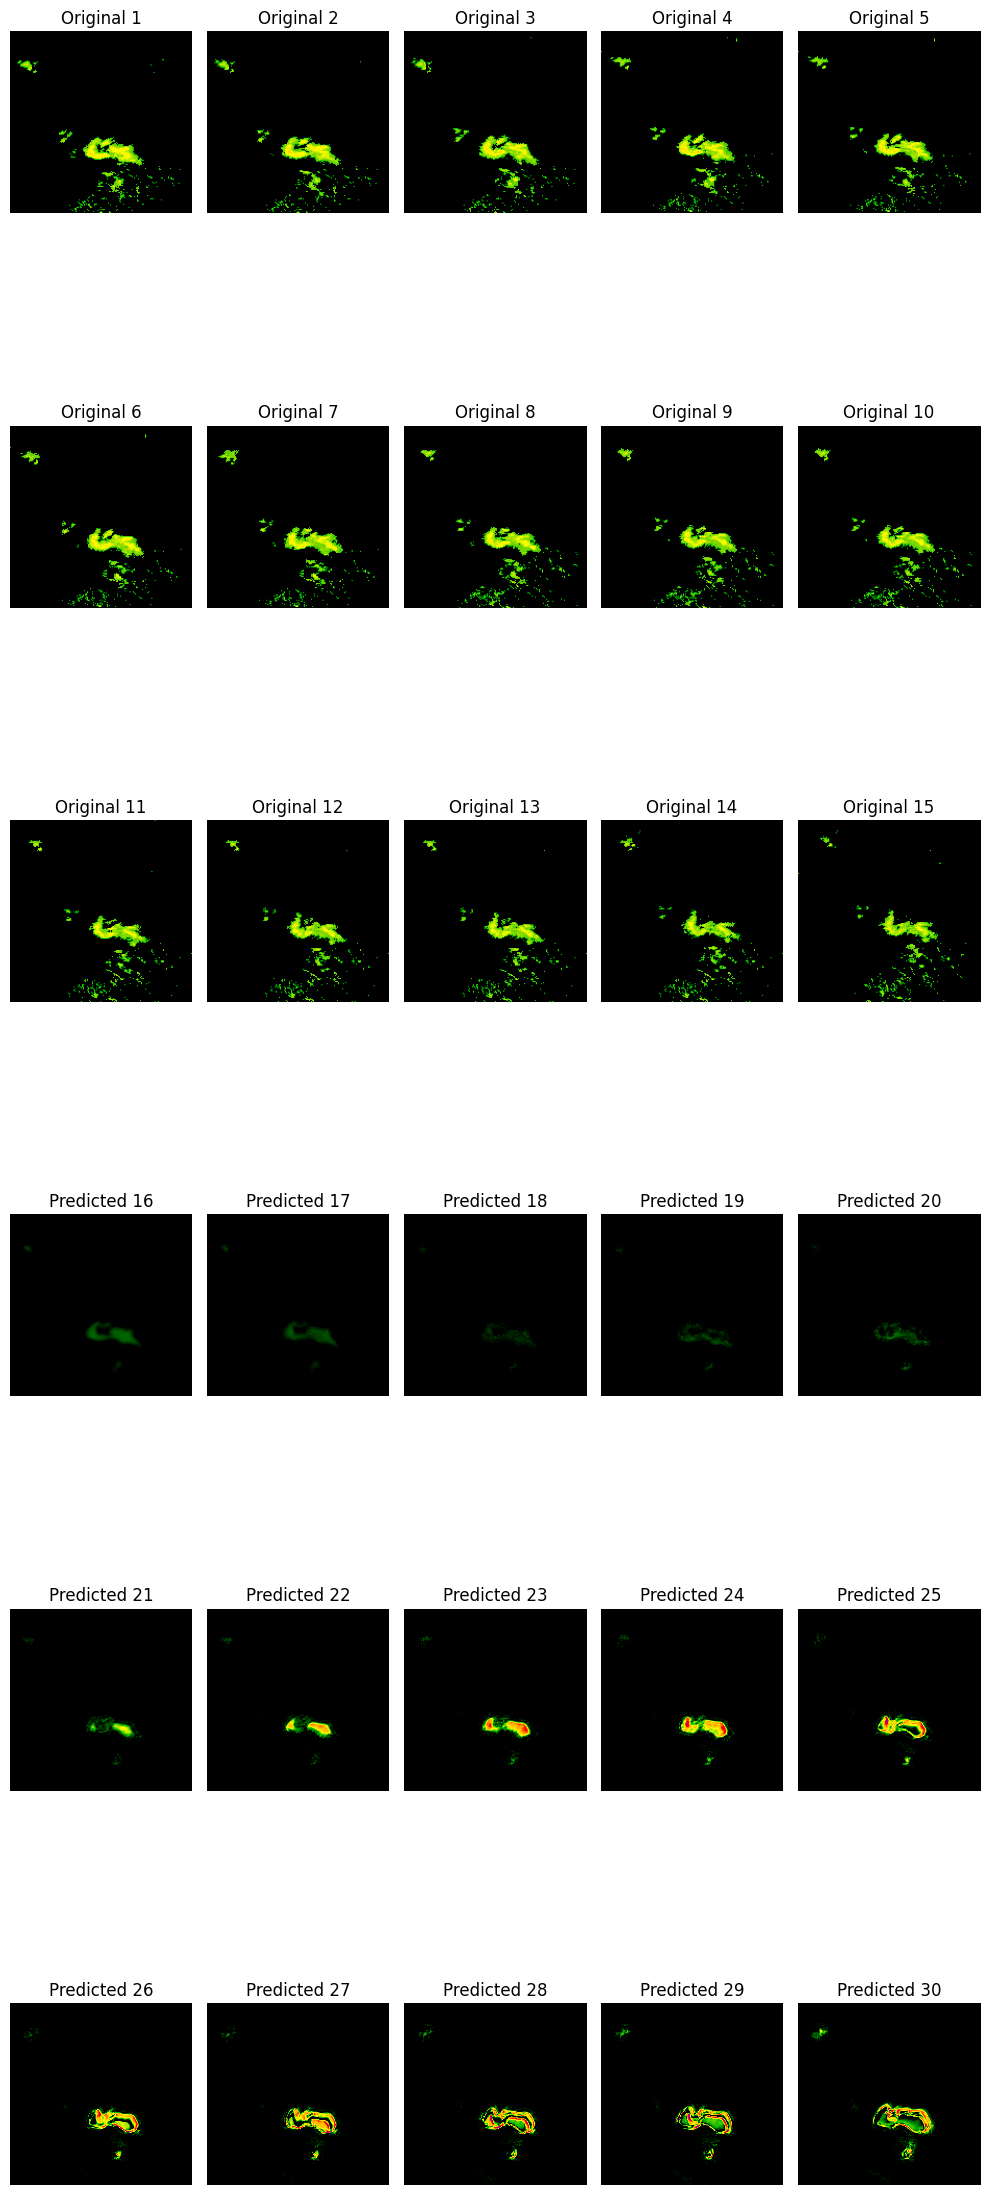

In [43]:
# Sample 15 frames randomly from X_val
frames = X_unique[np.random.choice(range(len(X_unique)), size=1)[0]]

# Predict a new set of frames
predicted_frames = model.predict(np.expand_dims(frames, axis=0))
predicted_frames = np.squeeze(predicted_frames, axis=0)

# Construct a figure for the original and predicted frames (5 rows of 3 columns each)
fig, axes = plt.subplots(6, 5, figsize=(10, 25))  # 5 rows for original + 5 rows for predicted, 3 columns each

# Plot the original frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    ax.imshow(np.squeeze(frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Original {idx + 1}")
    ax.axis("off")

# Plot the predicted frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row + 3, col]  # Offset by 5 rows to separate original and predicted
    ax.imshow(np.squeeze(predicted_frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Predicted {idx + 16}")
    ax.axis("off")

# Display the figure
plt.tight_layout()
plt.show()